 <h2 align="center">project1</h2>

## <font color=blue>במערך הנתונים, תקבלו נתונים של חנויות שונות של חברת סופרמרקט לפי מזהה החנות שלהם, שהומרו למספרים שלמים חיוביים
 <font color=red>
    מזהה חנות: מזהה (אינדקס) של החנות הספציפית.<br>
Store_Area: שטח פיזי של החנות בכיכר החצר.<br>
Items_Available: מספר פריטים שונים הזמינים בחנות המתאימה.<br>
DailyCustomerCount: מספר הלקוחות שביקרו בחנויות בממוצע על פני חודש.<br>
Store_Sales: מכירות ב-(US $) שהחנויות ביצעו.


Q1:
עליך בנות אלגוריתם למידה שמנבה את מחירות של חנות ספציפית  ( ערך מספרי)


# IMPORTING LIBRARIES AND LOADING DATA


In [711]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import plotly.express as px


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRegressor , XGBClassifier
from catboost import CatBoostRegressor,CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold

In [712]:
# Load and preprocess the data
data = pd.read_csv('Stores.csv')
#set number format
pd.options.display.float_format = '{:.2f}'.format
#Limiting floats output to 2 decimal points

In [713]:
#check DATA columns
data.columns

Index(['Store ID ', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

In [714]:
# Drop the Store ID column
data = data.drop('Store ID ', axis=1)

In [715]:
data.head().T

,0,1,2,3,4
Store_Area,1659,1461,1340,1451,1770
Items_Available,1961,1752,1609,1748,2111
Daily_Customer_Count,530,210,720,620,450
Store_Sales,66490,39820,54010,53730,46620


## EXPLORATORY DATA ANALYSIS-EDA


Store_Area: mu = 1485.41, sigma = 250.10
Store_Area: Skewness: 0.03
Store_Area: Kurtosis: -0.28


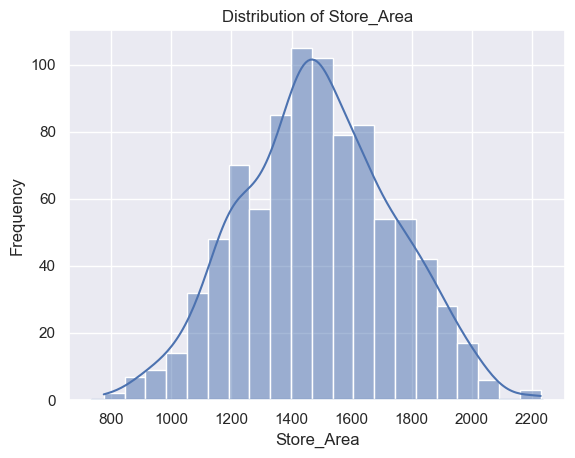

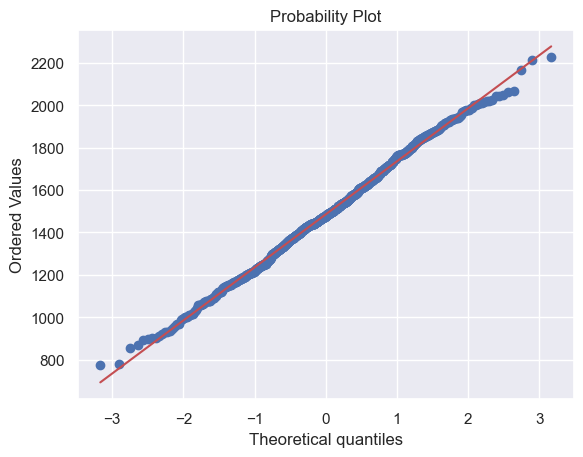

Items_Available: mu = 1782.04, sigma = 299.70
Items_Available: Skewness: 0.03
Items_Available: Kurtosis: -0.28


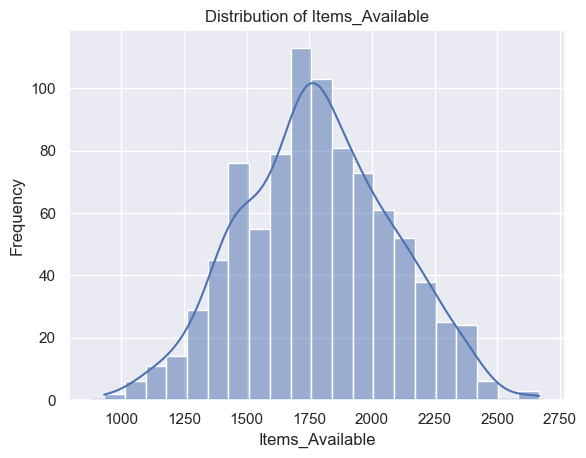

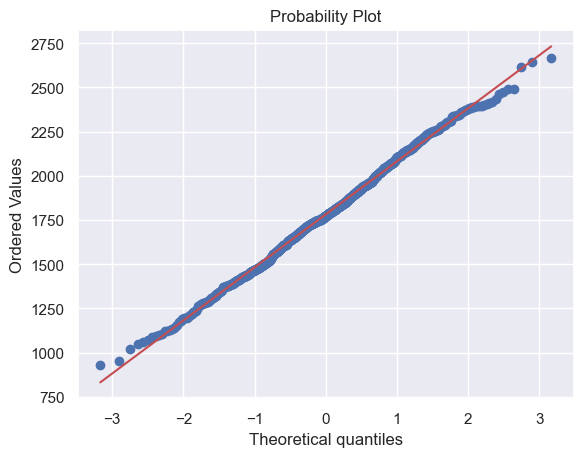

Daily_Customer_Count: mu = 786.35, sigma = 265.24
Daily_Customer_Count: Skewness: 0.07
Daily_Customer_Count: Kurtosis: -0.26


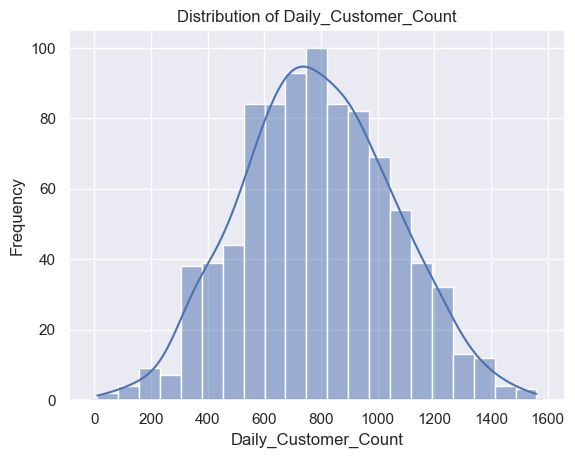

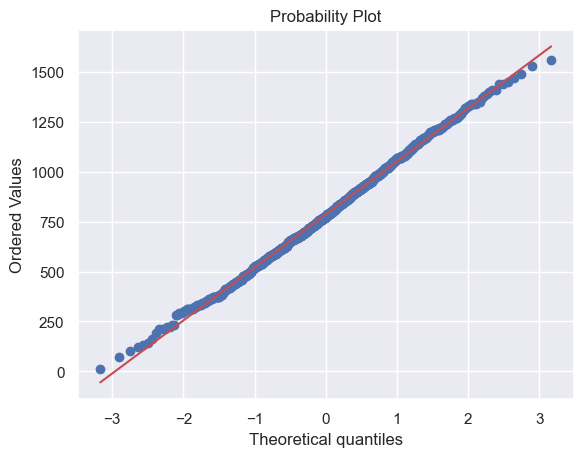

Store_Sales: mu = 59351.31, sigma = 17181.15
Store_Sales: Skewness: 0.15
Store_Sales: Kurtosis: -0.46


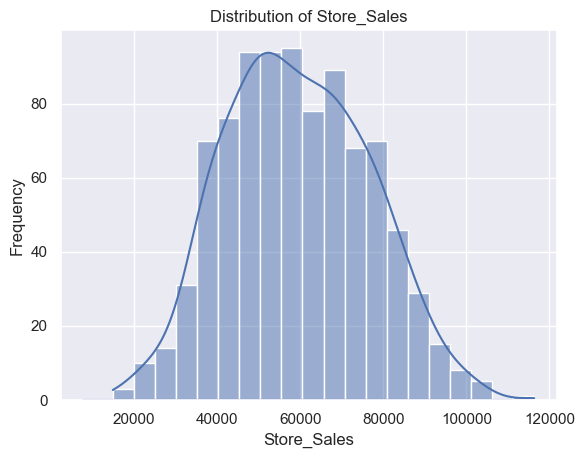

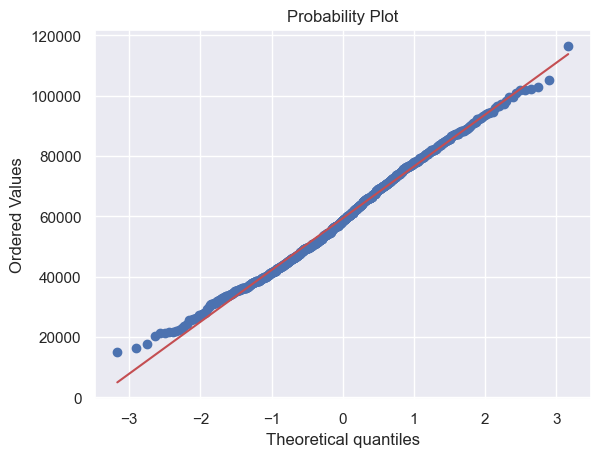

In [633]:
# Create a list of the columns you want to analyze
columns = ['Store_Area', 'Items_Available', 'Daily_Customer_Count', 'Store_Sales']

# Loop over the columns and plot the distribution of each variable
for col in columns:
    # Plot the distribution of the data
    sns.histplot(data[col], kde=True)

    # Fit a normal distribution to the data
    (mu, sigma) = stats.norm.fit(data[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))

    # Calculate the skewness and kurtosis of the data
    print('{}: Skewness: {:.2f}'.format(col, data[col].skew()))
    print('{}: Kurtosis: {:.2f}'.format(col, data[col].kurt()))
#סקיווינס הוא מדד לצדקה האם התפלגות הנתונים מתארת חציון ממוצע או שהיא מטויחת ומאונכת לצד אחד
#קורטוזיס הוא מדד לצדקה האם התפלגות הנתונים מתארת פיזור הפקות גבוהות או נמוכות מהממוצע, כך שזו מתארת גם את הקשיחות של התפלגות הנתונים.

    # Add the fitted normal distribution to the plot
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')

    # Add labels and title to the plot
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))

    # Plot the QQ-plot
    fig = plt.figure()
    stats.probplot(data[col], plot=plt)

    plt.show()

#### הקוד מבצע ניתוח נתונים על חמש עמודות ומציג עבור כל אחד מהם התפלגות עם קו כיפה<br>
#### להערכת התפלגות הנתונים ומשווה אותם להתפלגות נורמלית. <br> 
#### המטרה היא להשוואת התפלגות הנתונים להתפלגות נורמלית לכל עמודה<br>
#### ומציג גם גרף plot<br> 
#### לבדוק את תפיסת הנתונים ולזהות עיוותים אפשריים לפני ביצוע ניתוחים סטטיסטיים<br>.
<div style="text-align: right"> 
:הסבר אחד התוצאות לדוגמה<br>
Store_Area: השטח הממוצע של החנות הוא 1485.41 יחידות מרביות
<br>, והסטיית תקן היא 250.10.(standard deviation )<br> 
זה מציין שאזורי החנויות יחסית קבועים בגודלם, עם רובם נפולים בטווח של פלוס או מינוס 250 יחידות מרביות מהממוצע. עם זאת, הנתונים מעט שטוחים, מה שאומר שאין הרבה שוני בשטח החנות.

In [716]:
data.corr()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store_Area,1.00,1.00,-0.04,0.10
Items_Available,1.00,1.00,-0.04,0.10
Daily_Customer_Count,-0.04,-0.04,1.00,0.01
Store_Sales,0.10,0.10,0.01,1.00


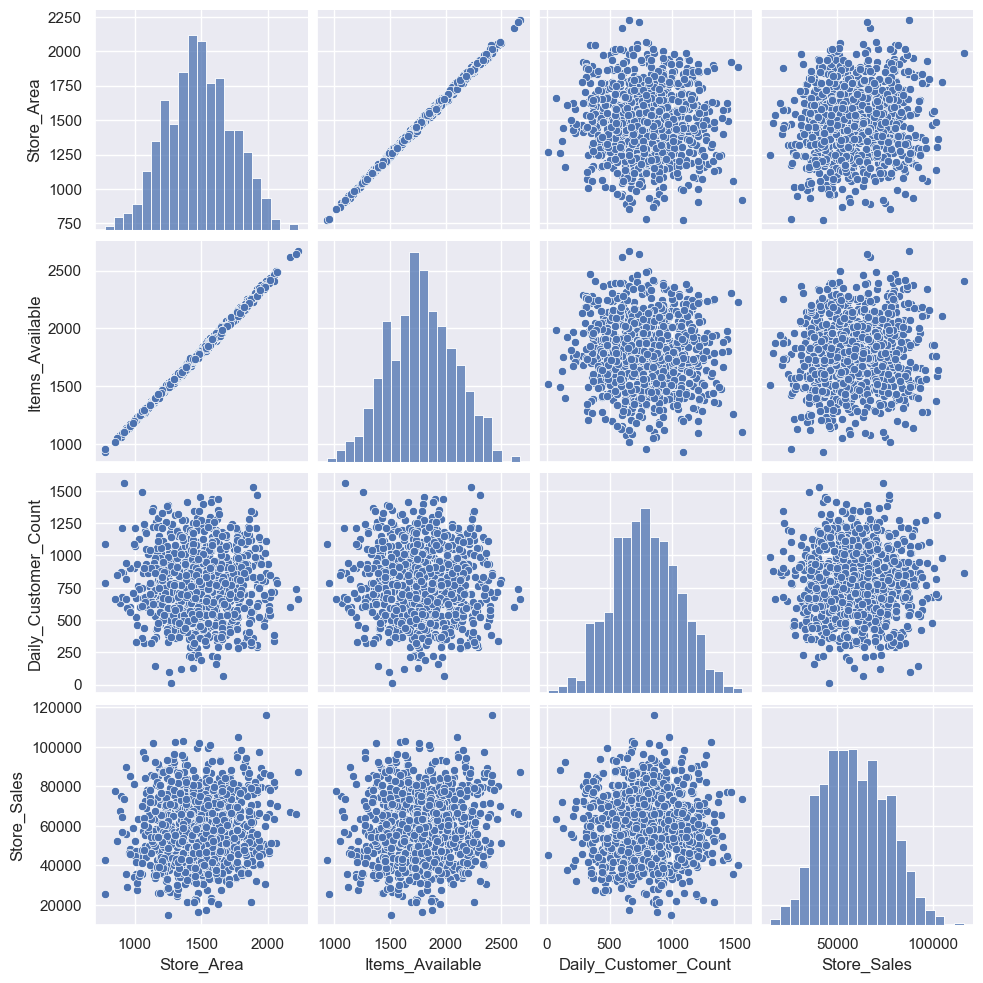

In [634]:
df = data[['Store_Area', 'Items_Available', 'Daily_Customer_Count', 'Store_Sales']]

sns.pairplot(df, kind="scatter")

plt.show()

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store_Area,1.00,1.00,-0.04,0.10
Items_Available,1.00,1.00,-0.04,0.10
Daily_Customer_Count,-0.04,-0.04,1.00,0.01
Store_Sales,0.10,0.10,0.01,1.00


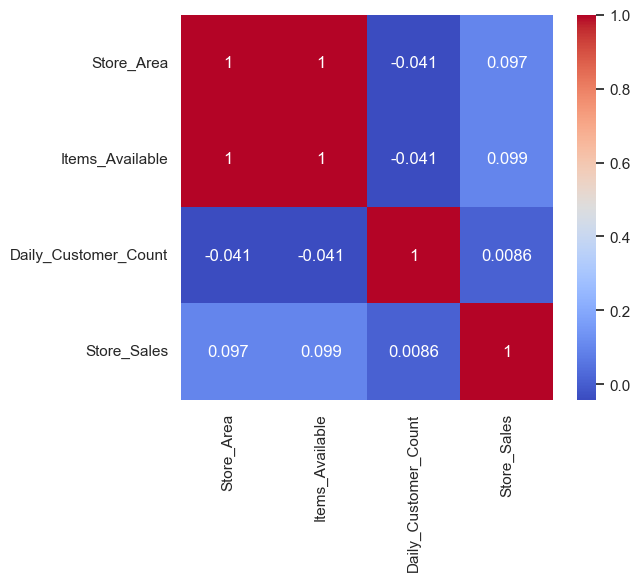

In [717]:
#check correlation
#השורה הזו בקוד בודקת את הקורלציה בין המשתנים בסט הנתונים על ידי מטריצת הקורלציה
plt.figure(figsize=(6,5))
#מחשב את מטריצת הקורלציות של כל המשתנים בטבלה ושומר את זה במשתנה
correlation = data.corr()
#הפקודה מציירת מפת חום:שהערכים הנמוכים מוצגים בכחול קר,והערכים הגבוהים מוצגים באדום חם
sns.heatmap(correlation,cmap="coolwarm",annot=True)
#מחזיר את המטריצה של הקורלציות
correlation

מפת הקורלציה מציגה כיצד המשתנים בטבלה מתאימים אחד לשני,
ערך של 1 מציין שני משתנים הם בקורלציה חיובית מושלמת,
ערך של 0 מציין כי לא קיימת קורלציה,
ערך של -1 מציין שני משתנים הם בקורלציה שלילית מושלמת,
עם 'cmap = "coolwarm"' אנו מגדירים את צבעי המפה לכחול וקר לערך הנמוך וחם ואדום לערך הגבוה,
עם הפקד "annot = True" אנו מוסיפים את הערכים של הקורלציות לתוך התאים,
לפי המפה הזאת אפשר להבין שהקשר בין המשתנים לא חזק

# Data Cleaning and Data Prepare


In [718]:
# Step 1: check missing ratio
data_na = (data.isnull().sum() / len(data)) * 100
print(data_na)
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:25]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(20)


Store_Area             0.00
Items_Available        0.00
Daily_Customer_Count   0.00
Store_Sales            0.00
dtype: float64


,Missing Ratio


### No null in this dataset
הקוד הזה משמש לבדיקת נתונים חסרים בקובץ נתונים שנקרא "data"
. הוא מציג את העמודות בקובץ ואת אחוז הנתונים החסרים בכל עמוד.
לאחר מכן, הוא ממיין את העמודות לפי כמות הנתונים החסרים בהם ומציג את 25 העמודות עם הנתונים החסרים הגבוהים ביותר ואת כמות הנתונים החסרים בהם.
המידע הזה עוזר לזהות אילו עמודות בקובץ נתונים מכילות הכי הרבה נתונים חסרים וצריכות להיות מתוקנות לפני שימוש נוסף בקובץ.






In [719]:
# Step 2: Handle duplicates
duplicate_rows_data = data[data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (0, 4)


In [720]:
data= data.drop_duplicates()

Outliers in Store_Area: [2169, 775, 2229, 2214, 780]


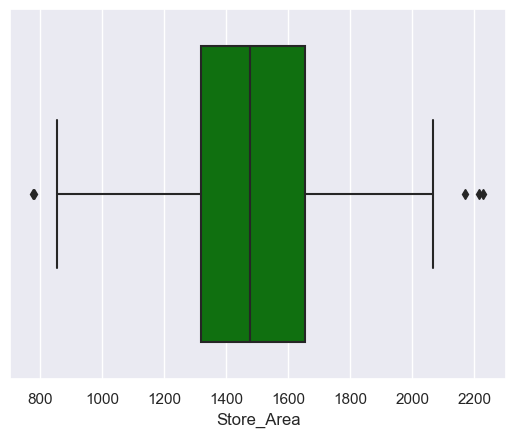

Outliers in Items_Available: [2617, 932, 2667, 2647, 951]


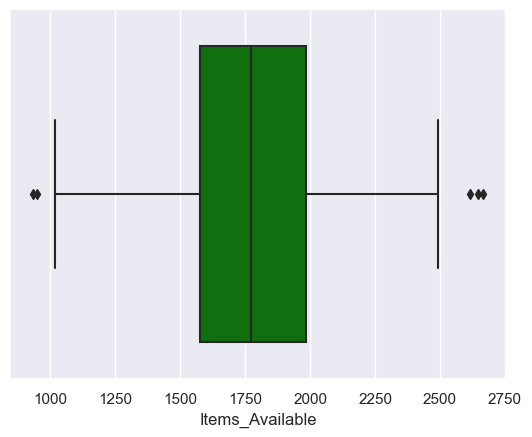

Outliers in Daily_Customer_Count: [10, 1530, 1560]


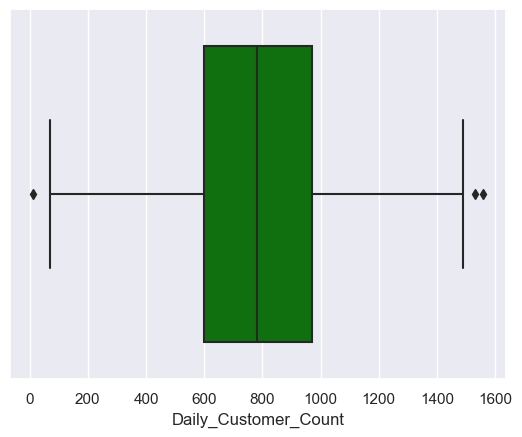

In [721]:
# Step 3: Handling Outliers
# Create boxplots and print outliers for each variable
for col in data.columns:
    if col != 'Store_Sales':
        Q1 = data[col].quantile(0.25)
        # מחשבת את הקוונטיל 0.25, כלומר את הערך שמתחת לו 25% מהערכים בטבלה לעמודה הנוכחית. 
        Q3 = data[col].quantile(0.75)
        #מחשבת את הקוונטיל 0.75, כלומר את הערך שמתחת לו 75% מהערכים בטבלה לעמודה הנוכחית
        IQR = Q3 - Q1
        #מחשבת את הטווח האינטרקוורטילי, כלומר את ההפרש בין קוונטיל 0.25 לקוונטיל 0.75
        outlier_mask = (data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))
        # below Q1 - 1.5IQR or above Q3 + 1.5IQR are considered outliers 
        outliers = data[outlier_mask][col].tolist()
        print(f"Outliers in {col}: {outliers}")
        sns.boxplot(x=data[col],color='green')
        plt.show()

In [722]:
# Remove outliers from Store_Area and Items_Available
Q1 = data['Store_Area'].quantile(0.25)
Q3 = data['Store_Area'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['Store_Area'] < (Q1 - 1.5 * IQR)) | (data['Store_Area'] > (Q3 + 1.5 * IQR)))]

Q1 = data['Items_Available'].quantile(0.25)
Q3 = data['Items_Available'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['Items_Available'] < (Q1 - 1.5 * IQR)) | (data['Items_Available'] > (Q3 + 1.5 * IQR)))]

<div style="text-align: right"> 

לחריגים יכולים להיות השפעה משמעותית על ניתוחים סטטיסטיים ומודלים של למידת מכונה. הם יכולים להטות את התפלגות הנתונים, ולגרום למודל לבצע תחזיות או הערכות שגויות. <div style="text-align: right"> לכן, חשוב לטפל בצורה מתאימה עם חריגים.
</div>
    <div style="text-align: right"> 
 Store_Area ו-Items_Availableבמקרה זה, החלטנו להסיר את החריגים עבור
<br>    , מכיוון שהם היו מועטים יחסית במספרם ונראה היה שהם ערכים קיצוניים שלא סביר שייצגו את רוב הנתונים. על ידי הסרת חריגים אלה, נוכל לשפר את הדיוק והאמינות של הניתוח והמודלים שלנו.<br>
      Daily_Customer_Count עם זאת, לא הסרנו את החריגים עבור <br>
        מכיוון שהיו רק מעטים מהם, ונראה שהם לא היו ערכים קיצוניים שספק אם ייצגו את רוב הנתונים.
     </div>

Outliers in Store_Area: []


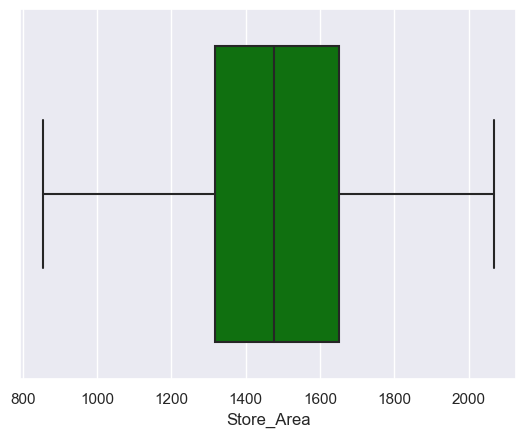

Outliers in Items_Available: []


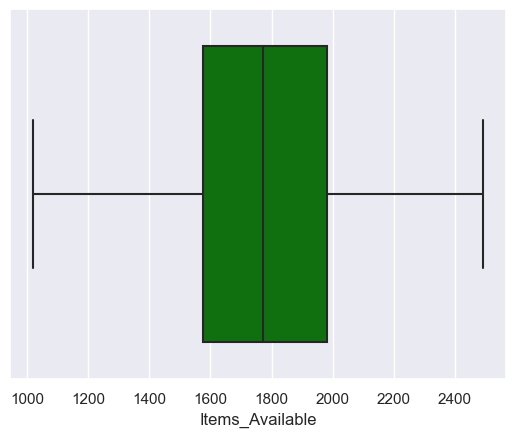

Outliers in Daily_Customer_Count: [10, 1530, 1560]


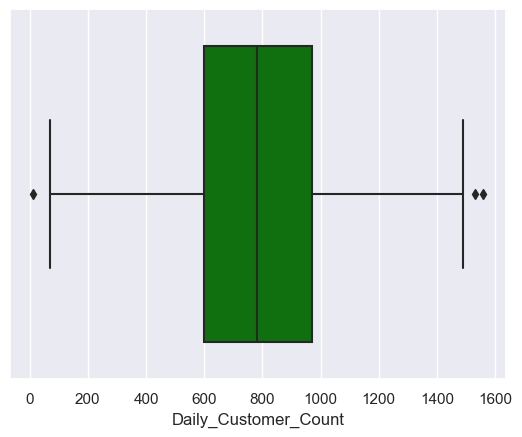

In [723]:
# Step 3: Handling Outliers
# Create boxplots and print outliers for each variable
for col in data.columns:
    if col != 'Store_Sales':
        Q1 = data[col].quantile(0.25)
        # מחשבת את הקוונטיל 0.25, כלומר את הערך שמתחת לו 25% מהערכים בטבלה לעמודה הנוכחית. 
        Q3 = data[col].quantile(0.75)
        #מחשבת את הקוונטיל 0.75, כלומר את הערך שמתחת לו 75% מהערכים בטבלה לעמודה הנוכחית
        IQR = Q3 - Q1
        #מחשבת את הטווח האינטרקוורטילי, כלומר את ההפרש בין קוונטיל 0.25 לקוונטיל 0.75
        outlier_mask = (data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))
        # below Q1 - 1.5IQR or above Q3 + 1.5IQR are considered outliers 
        outliers = data[outlier_mask][col].tolist()
        print(f"Outliers in {col}: {outliers}")
        sns.boxplot(x=data[col],color='green')
        plt.show()

In [724]:
data

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1659,1961,530,66490
1,1461,1752,210,39820
2,1340,1609,720,54010
3,1451,1748,620,53730
4,1770,2111,450,46620
...,...,...,...,...
891,1582,1910,1080,66390
892,1387,1663,850,82080
893,1200,1436,1060,76440
894,1299,1560,770,96610


# Making a Prediction

In [725]:
# Split the dataset
X = data[['Store_Area', 'Items_Available', 'Daily_Customer_Count']]
y = data['Store_Sales']


In [726]:
X.shape

(891, 3)

In [727]:
sc = StandardScaler()
X = sc.fit_transform(X)

הקוד שצוין מבצע סטנדרטיזציה של הנתונים והיא תהליך שמטרתו להעביר את הנתונים לסקייל מסוים, כך שהם יהיו יותר נוחים לעיבוד ולניתוח על ידי מודלי למידה ואלגוריתמים.

In [728]:
X=pd.DataFrame(X, columns =['Store_Area', 'Items_Available', 'Daily_Customer_Count'])

creates a new DataFrame called X with the same values as the original X array, but with column names assigned to each of the columns.

C:\Users\Lenovo\pr\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Lenovo\pr\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Lenovo\pr\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Lenovo\pr\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THRE

Text(0, 0.5, 'Inertia')

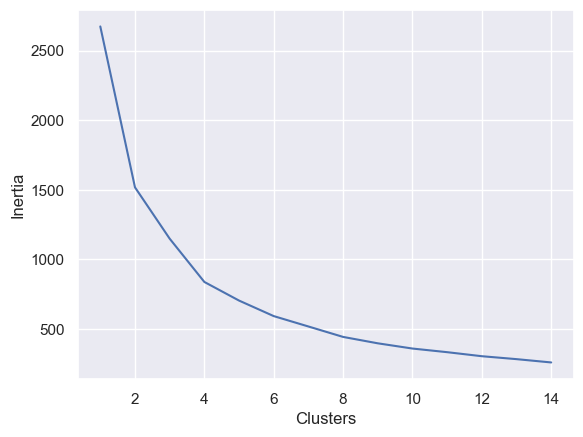

In [647]:

clusters = []

for i in range(1, 15):
    km = KMeans(n_clusters=i).fit(X)
    clusters.append(km.inertia_)
    
sns.lineplot(x=list(range(1, 15)), y=clusters)
plt.xlabel('Clusters')
plt.ylabel('Inertia')

We learned from the graph above, that the data can be grouped into 10 different groups to classify it for purchasing power of customers

In [495]:
km_10 = KMeans(n_clusters=10).fit(X)


C:\Users\Lenovo\pr\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Lenovo\pr\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [496]:
X['Labels'] =km_10.labels_

In [650]:
X

,Store_Area,Items_Available,Daily_Customer_Count
0,1659,1961,530
1,1461,1752,210
2,1340,1609,720
3,1451,1748,620
4,1770,2111,450
...,...,...,...
891,1582,1910,1080
892,1387,1663,850
893,1200,1436,1060
894,1299,1560,770


In [729]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [730]:
X_train

,Store_Area,Items_Available,Daily_Customer_Count
331,0.55,0.60,1.86
733,-1.48,-1.46,0.43
382,0.28,0.24,-1.30
704,0.85,0.85,-0.66
813,0.50,0.62,-0.06
...,...,...,...
106,1.81,1.80,-0.59
270,-0.68,-0.72,1.52
860,1.48,1.41,1.44
435,0.12,0.13,-1.00


In [733]:
# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
  
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGB": XGBRegressor(random_state = 116),
    "CatBoostRegressor": CatBoostRegressor(random_state =116, verbose = 0),
"LogisticRegression": LogisticRegression()
    
  
}

In [738]:
# Train and evaluate the models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)# calculates the R-squared value between the predicted and actual target values of a regression model. This value indicates how well the model fits the observed data, with higher values indicating a better fit.
   
    results.append({"Model": name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2})

results_df = pd.DataFrame(results)

In [735]:
results_df

,Model,MAE,MSE,RMSE,R2
0,Linear Regression,13689.23,282626338.70,16811.49,0.01
1,Ridge Regression,13682.85,281952991.45,16791.46,0.02
2,Decision Tree,18174.30,517700482.68,22753.03,-0.81
3,Random Forest,14581.55,328027940.23,18111.54,-0.14
4,XGB,15128.96,354972332.31,18840.71,-0.24
5,CatBoostRegressor,14020.76,312023262.15,17664.18,-0.09
6,LogisticRegression,19371.56,569817348.04,23870.85,-0.99


NameError: name 'y_head_lr' is not defined

**Visualize the results**

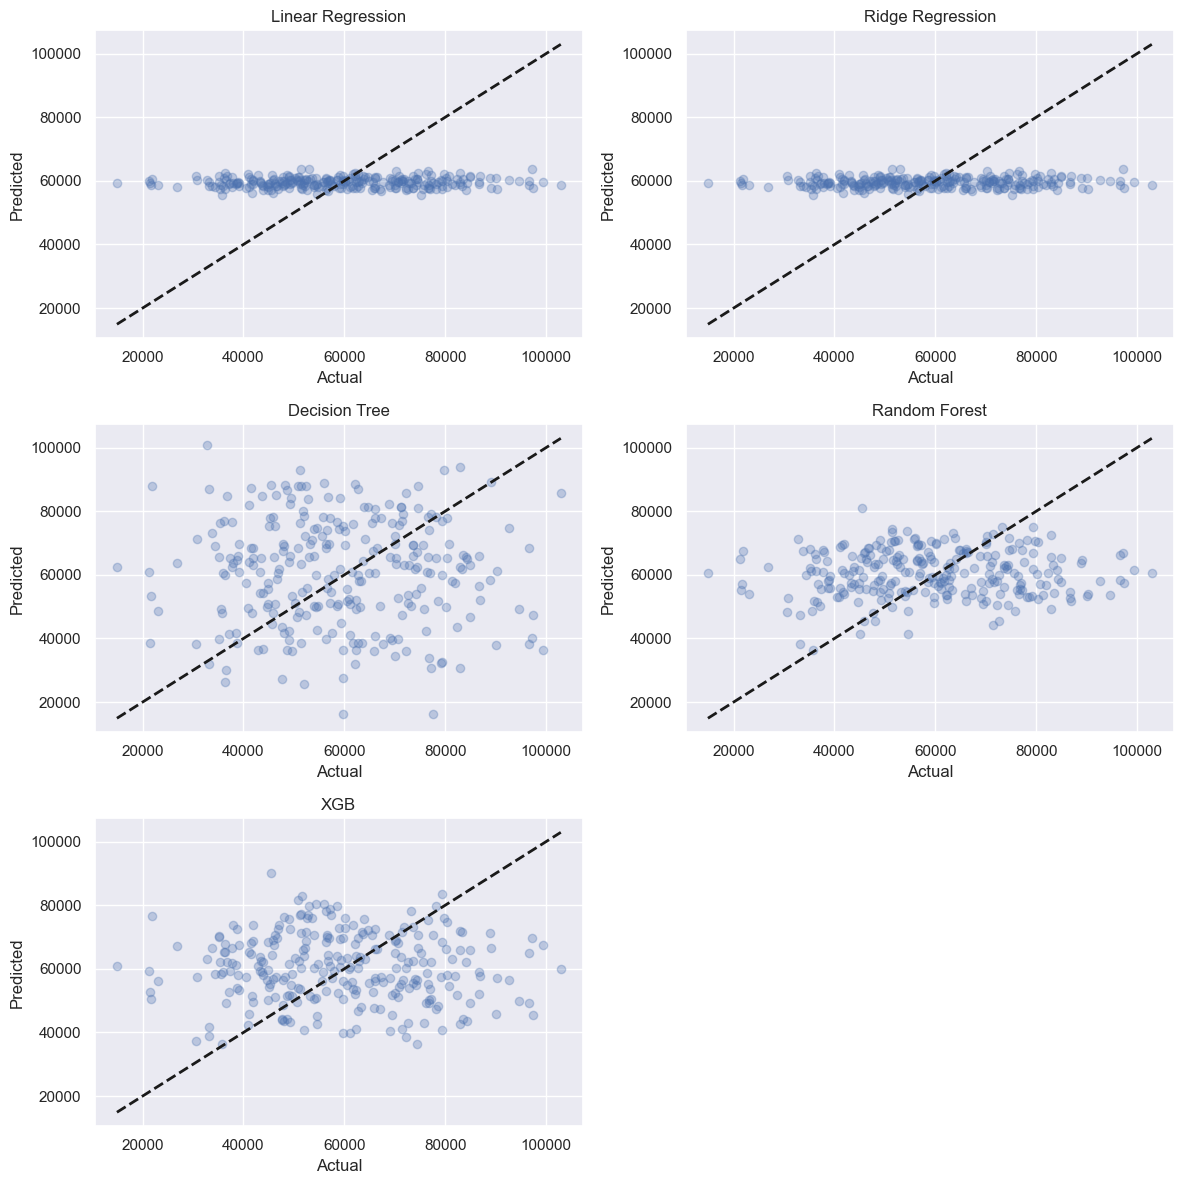

In [288]:
# Scatter plot of actual vs predicted values
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.ravel()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    axes[i].scatter(y_test, y_pred, alpha=0.3)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[i].set_xlabel("Actual")
    axes[i].set_ylabel("Predicted")
    axes[i].set_title(f"{name}")

# Remove extra subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [ ]:
!pip install xgboost



In [289]:
xgbr = XGBRegressor(random_state = 116)
xgbr.fit(X_train, y_train)
xgbr_pred =xgbr.predict(X_test)

In [290]:
mse = mean_squared_error(y_test, xgbr_pred)
rmse = np.sqrt(mean_squared_error(y_test, xgbr_pred))
mae = mean_absolute_error(y_test, xgbr_pred)

score = xgbr.score(X_train, y_train) 
scores = cross_val_score(xgbr, X_train, y_train,cv=10)
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
r2 =r2_score(y_test,  xgbr_pred)

In [291]:
print('XGB Regressor')
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("MAE: %.2f" % (mae))
print("Training score: ", score)
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print("R_score : %.2f"%(r2))

XGB Regressor
MSE: 419045123.57
RMSE: 20470.59
MAE: 16779.92
Training score:  0.965145555449008
Mean cross-validation score: -0.33
K-fold CV average score: -0.41
R_score : -0.46


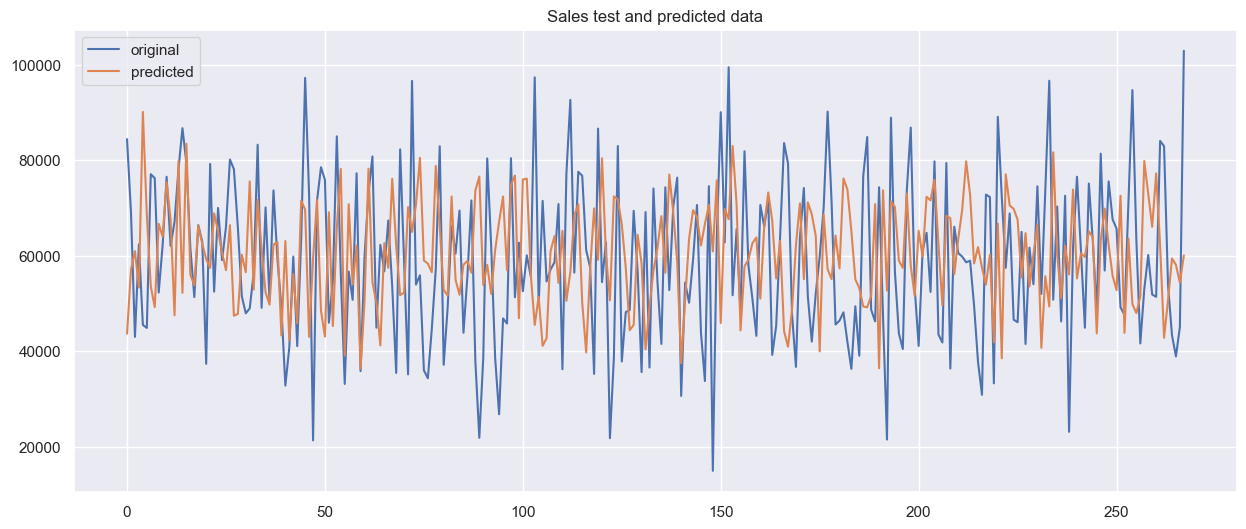

In [292]:
plt.figure(figsize = (15, 6))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, xgbr_pred, label="predicted")
plt.title("Sales test and predicted data")
plt.legend()
plt.show()

In [ ]:
!pip install catboost

In [293]:
cbr = CatBoostRegressor(random_state =116, verbose = 0)
cbr.fit(X_train, y_train)
cbr_pred =cbr.predict(X_test)

In [294]:
mse = mean_squared_error(y_test, cbr_pred)
rmse = np.sqrt(mean_squared_error(y_test, cbr_pred))
mae = mean_absolute_error(y_test, cbr_pred)

score = cbr.score(X_train, y_train) 
scores = cross_val_score(cbr, X_train, y_train,cv=10)
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(cbr, X_train, y_train, cv=kfold )
r2 =r2_score(y_test,  cbr_pred)

In [295]:
print('CatBoost Regressor')
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("MAE: %.2f" % (mae))
print("Training score: ", score)
print("Mean cross-validation score: %.2f" % scores.mean())
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
print("R_score : %.2f"%(r2))

CatBoost Regressor
MSE: 316784590.82
RMSE: 17798.44
MAE: 14711.14
Training score:  0.5960054137255926
Mean cross-validation score: -0.15
K-fold CV average score: -0.19
R_score : -0.10


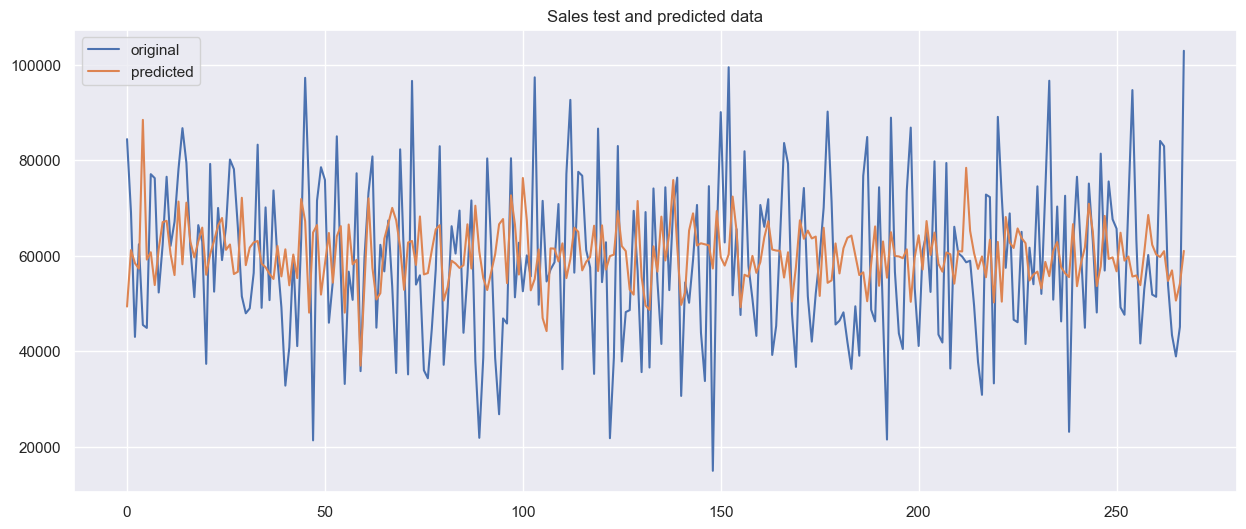

In [296]:
plt.figure(figsize = (15, 6))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, cbr_pred, label="predicted")
plt.title("Sales test and predicted data")
plt.legend()
plt.show()

# Q2:לחלק מחירות ל-2 קבוצות (גבוהה או נמוך) ולבנות אלגוריתם סווג

In [518]:
df=df.drop(columns=['income'])

KeyError: "['income'] not found in axis"

In [610]:
from sklearn.metrics import confusion_matrix ,recall_score , classification_report , precision_score , f1_score


In [678]:
df = data

In [679]:
average = df['Store_Sales'].mean()
print('The average of column_name is:', average)

The average of column_name is: 59360.54994388328


In [680]:
df['income_above_average']=df['Store_Sales'].apply(lambda x: x>=average)

In [681]:
df['income_above_average'] = df['income_above_average'].replace({True: 'True', False: 'False'})

In [682]:
df=df.drop(columns=['Store_Sales'])

In [736]:
df


,Store_Area,Items_Available,Daily_Customer_Count,income_above_average
0,1659,1961,530,True
1,1461,1752,210,False
2,1340,1609,720,False
3,1451,1748,620,False
4,1770,2111,450,False
...,...,...,...,...
891,1582,1910,1080,True
892,1387,1663,850,True
893,1200,1436,1060,True
894,1299,1560,770,True


In [683]:
df['income_above_average']

0       True
1      False
2      False
3      False
4      False
       ...  
891     True
892     True
893     True
894     True
895    False
Name: income_above_average, Length: 891, dtype: object

In [684]:
# Split the dataset
X = df[['Store_Area', 'Items_Available', 'Daily_Customer_Count']]
y = df['income_above_average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [685]:
# Define the models
models = {
 
    "CatBoostClassifier": CatBoostClassifier(random_state =116, verbose = 0) ,
    "RandomForestClassifier": RandomForestClassifier(),
"LogisticRegression": LogisticRegression()
    
  
}

In [698]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred,y_test)
  
    results.append({"Model": name, "acc": acc})

results_df = pd.DataFrame(results)



In [691]:
results_df

,Model,acc
0,CatBoostClassifier,0.50
1,RandomForestClassifier,0.49
2,LogisticRegression,0.51


In [619]:
recall_score(y_test,cf_y_pred, average='macro')


0.5008928571428571

In [616]:
precision_score(y_test,cf_y_pred, average='macro')


0.5009056432897493

In [614]:
f1_score(y_test.to_numpy(),cf_y_pred, average='macro')

0.5000490918016691

In [572]:
cf_y_pred = models["CatBoostClassifier"].predict(X_test)

In [557]:
cm_lr = confusion_matrix(y_test,cf_y_pred)

In [573]:
cf_y_pred

array(['True', 'True', 'True', 'False', 'True', 'False', 'True', 'False',
       'False', 'True', 'True', 'False', 'False', 'True', 'False', 'True',
       'True', 'False', 'True', 'True', 'False', 'True', 'True', 'True',
       'True', 'True', 'True', 'False', 'False', 'True', 'False', 'False',
       'True', 'True', 'False', 'False', 'False', 'False', 'False',
       'False', 'False', 'False', 'True', 'False', 'False', 'True',
       'False', 'True', 'True', 'False', 'False', 'False', 'False',
       'True', 'True', 'False', 'True', 'False', 'True', 'False', 'True',
       'True', 'False', 'False', 'False', 'True', 'False', 'True', 'True',
       'False', 'False', 'True', 'True', 'False', 'True', 'False',
       'False', 'False', 'False', 'True', 'False', 'False', 'False',
       'False', 'False', 'False', 'True', 'False', 'True', 'False',
       'False', 'False', 'False', 'False', 'True', 'True', 'False',
       'True', 'True', 'False', 'True', 'True', 'False', 'False', 'False',
   

In [554]:
cm_lr


array([[79, 61],
       [72, 56]], dtype=int64)

<Axes: title={'center': 'CatBoostClassifier Confusion Matrix'}>

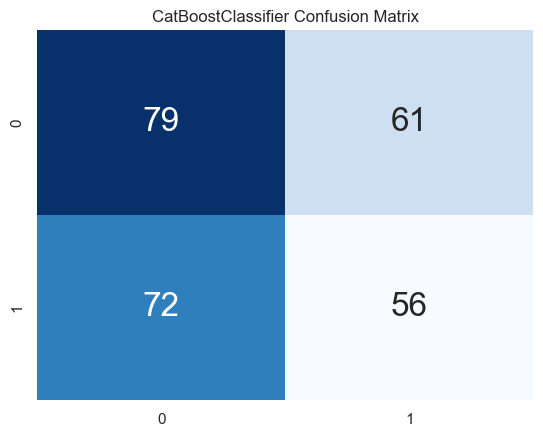

In [675]:
plt.title("CatBoostClassifier Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

model predict negative and the truth is negative:TN:79<br>
        model positive  and the truth is negative:fp:61<br>
        model predict negative and the truth is positive:fn:72<br>
        model predict positive and the truth is positive:tp:56<br>
        

#  TO IMPROVE

בגרף הקשר בין המכירות וגודל החנות אפשר לראות שיש חנויות שגודלם גדול אבל המכירות נמוכות וזה לא הגיוני או להפך חנות קטן ומס מכירות גדול*<br>
  בגרף הקשר בין מס מכירות ומס לקוחות אפשר לרות שיש בחנויות מכירות גדולות ומספר לקוחות קטן או להפך   *<br>
    ויש עוד תוצאות לא הגינית וצריך למחוק אותם